In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import linear_kernel
from scipy.spatial.distance import pdist, squareform

In [2]:
movie = pd.read_csv("C:/Users/nguye/Downloads/movies-1m.csv")

In [3]:
movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
ratings = pd.read_csv("C:/Users/nguye/Downloads/user_ratings-1m.csv")

In [5]:
import re

def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

movie["clean_title"] = movie["title"].apply(clean_title)

In [6]:
ratings

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


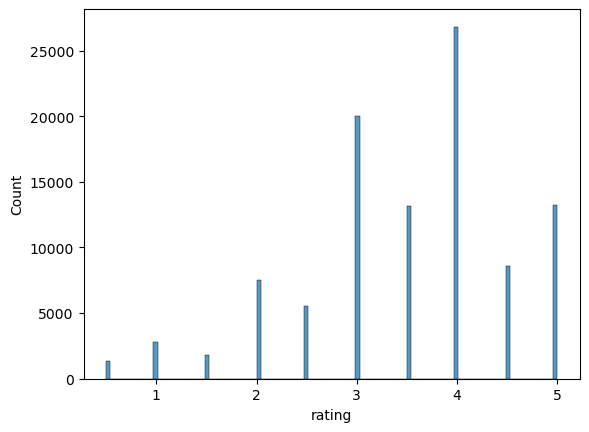

In [7]:
sns.histplot(ratings['rating'])
plt.show()

In [8]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [9]:
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader=reader)

# Define the algorithm (SVD in this case)
algo = SVD()

# Perform cross-validation
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the results
print("Mean RMSE:", results['test_rmse'].mean())
print("Mean MAE:", results['test_mae'].mean())

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8746  0.8702  0.8738  0.8714  0.8725  0.8725  0.0016  
MAE (testset)     0.6740  0.6711  0.6690  0.6696  0.6707  0.6709  0.0017  
Fit time          1.90    1.94    1.92    1.97    2.25    2.00    0.13    
Test time         0.53    0.23    0.24    0.24    0.23    0.29    0.12    
Mean RMSE: 0.872493010438118
Mean MAE: 0.67086137126505


In [10]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [11]:
algo.predict(603, 302, 3)

Prediction(uid=603, iid=302, r_ui=3, est=3.669459429835284, details={'was_impossible': False})

In [12]:
from surprise import accuracy
from surprise.model_selection import train_test_split

In [13]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.3)

# Train the matrix factorization model (SVD)
algorithm = SVD()
algorithm.fit(trainset)

# Make predictions on the test set
predictions = algorithm.test(testset)

# Evaluate the model's performance using Root Mean Squared Error (RMSE) on the test set
rmse = accuracy.rmse(predictions)
print(f"Test Set Root Mean Squared Error (RMSE): {rmse}")

# Create a masked test set using build_anti_testset()
masked_testset = trainset.build_anti_testset()

# Make predictions on the masked test set
masked_predictions = algorithm.test(masked_testset)

# Evaluate the model's performance using Root Mean Squared Error (RMSE) on the masked test set
masked_rmse = accuracy.rmse(masked_predictions)
print(f"Masked Test Set Root Mean Squared Error (RMSE): {masked_rmse}")

RMSE: 0.8795
Test Set Root Mean Squared Error (RMSE): 0.8794833407891528
RMSE: 0.4723
Masked Test Set Root Mean Squared Error (RMSE): 0.4723178011246939


In [21]:
def split_column_into_rows(df, column_name):
    # Split the column values into multiple rows
    df[column_name] = df[column_name].str.split('|')

    # Create a new dataframe with each feature in a separate row
    df = df.explode(column_name)

    # Reset the index of the expanded dataframe
    df.reset_index(drop=True, inplace=True)

    return df

movie = split_column_into_rows(movie, 'genres')
genres = pd.crosstab(movie['movieId'], movie['genres'])
genres

genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
193583,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
193585,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [22]:
j_dist = pdist(genres.values, metric='jaccard')
jaccard_similarity_array = 1 - squareform(j_dist)
jaccard_similarity_df = pd.DataFrame(jaccard_similarity_array, index=genres.index, columns=genres.index)

In [23]:
ratings2 = ratings.drop_duplicates(subset=['userId', 'movieId'])
user_rating = ratings2.pivot(index='userId', columns='movieId', values='rating')
user_rating= user_rating.fillna(0)
user_rating

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
user_item_interaction = user_rating.applymap(lambda rating: 1 if rating > 0 else 0)

In [25]:
user_item_interaction

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
607,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [41]:
movie['movieId'] = movie['movieId'].drop_duplicates()

In [26]:
# Step 1: Prepare the hybrid recommendation function
def hybrid_recommendation(user_id, user_item_matrix, item_genre_matrix, item_similarity_matrix, num_recommendations=5, alpha=0.5):
    # Get the items the user has interacted with
    user_interactions = user_item_matrix.loc[user_id].dropna().index
    
    # Content-based filtering: Recommend items based on genres
    genre_recommended_items = []
    for item_id in item_genre_matrix.index:
        if item_id not in user_interactions:
            # Calculate content-based score based on genres and user genre preferences
            content_score = sum(item_genre_matrix.loc[item_id] * user_item_matrix.loc[user_id, user_interactions])
            genre_recommended_items.append((item_id, content_score))
    
    # Sort the content-based recommended items by score
    genre_recommended_items.sort(key=lambda x: x[1], reverse=True)
    
    # Collaborative filtering: Recommend items based on item-item similarity
    collaborative_recommended_items = []
    for item_id in item_similarity_matrix.index:
        if item_id not in user_interactions:
            # Calculate collaborative filtering score based on item-item similarity and user-item interactions
            collaborative_score = sum(item_similarity_matrix.loc[item_id, user_interactions] * user_item_matrix.loc[user_id, user_interactions])
            collaborative_recommended_items.append((item_id, collaborative_score))
    
    # Sort the collaborative filtering recommended items by score
    collaborative_recommended_items.sort(key=lambda x: x[1], reverse=True)
    
    # Combine recommendations from content-based and collaborative filtering using alpha parameter
    hybrid_recommended_items = []
    for i in range(num_recommendations):
        hybrid_score = alpha * genre_recommended_items[i][1] + (1 - alpha) * collaborative_recommended_items[i][1]
        hybrid_recommended_items.append((genre_recommended_items[i][0], hybrid_score))
    
    # Sort the hybrid recommendations by score
    hybrid_recommended_items.sort(key=lambda x: x[1], reverse=True)
    
    return [item_id for item_id, _ in hybrid_recommended_items]

# Step 2: Get hybrid recommendations for a specific user
user_id = 1
hybrid_recommendations = hybrid_recommendation(user_id, user_rating, genres, jaccard_similarity_df, num_recommendations=5, alpha=0.5)
print("Hybrid Recommendations for User", user_id, ":", hybrid_recommendations)


Hybrid Recommendations for User 1 : [1076, 2939, 3338, 3456, 4194]


In [47]:
recommended_titles = movie[movie['movieId'].isin(hybrid_recommendations)]['title'].tolist()
print("Hybrid Recommendations (Movie Titles) for User", user_id, ":", recommended_titles)

Hybrid Recommendations (Movie Titles) for User 1 : ['Innocents, The (1961)', 'Niagara (1953)', 'For All Mankind (1989)', 'Color of Paradise, The (Rang-e khoda) (1999)', "I Know Where I'm Going! (1945)"]
